## Energy Calibration of Pulse Height Bins

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import scipy.stats as stat

In [2]:
Ba = pd.read_csv("barium.csv")
Cs = pd.read_csv("Cs60min.csv")
bg = pd.read_csv("background22hr.csv")

In [3]:
df_list = [Ba, Cs, bg]

In [4]:
for df in df_list:
    df.rename(columns={'   Channel':'Channel', '  Energy(keV)':'Energy', '   Counts':'Counts'},inplace=True)

In [5]:
def smooth(df, Wn):
    b, a = sig.butter(2, Wn, 'lp')
    return sig.filtfilt(b, a, df['Counts'])

def peaks(df, Wn, prom):
    peak_info = sig.find_peaks(smooth(df, Wn), prominence=prom)
    return [list(df['Channel'][peak_info[0]]), list(smooth(df, Wn)[peak_info[0]])]

In [6]:
def spectrum(df, Wn, prom):
    plt.figure(figsize=(15,7))
    plt.plot(df['Channel'], df['Counts'], color='grey', zorder=0)
    plt.plot(df['Channel'], smooth(df, Wn), color='k', zorder=1)
    plt.scatter(peaks(df, Wn, prom)[0], peaks(df, Wn, prom)[1], zorder=2, marker='x', color='b', s=60)
    plt.xlabel('Bin', size=16)
    plt.ylabel('Counts', size=16)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(0,None)


(0.0, 800.0)

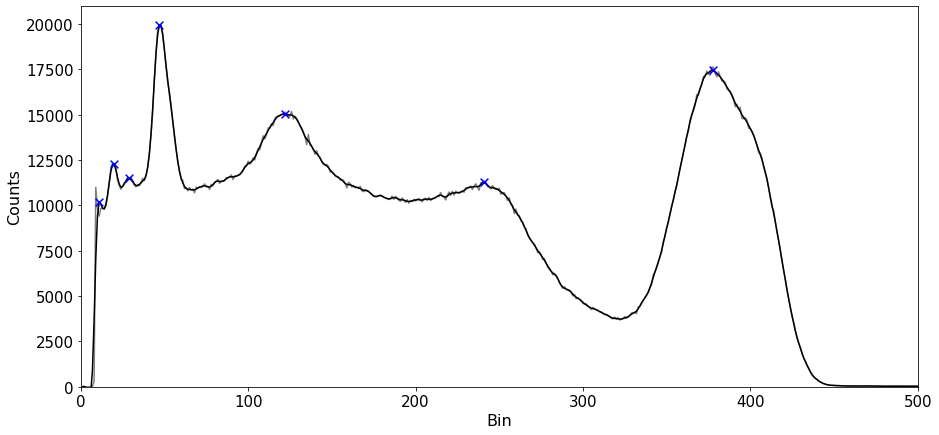

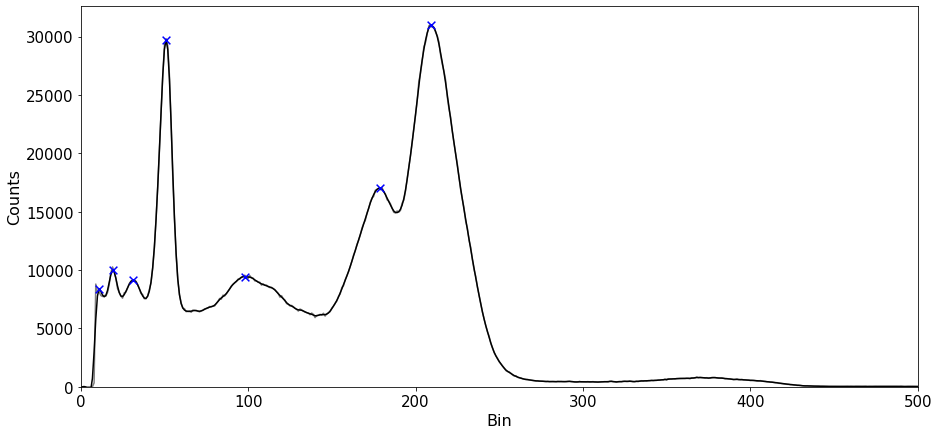

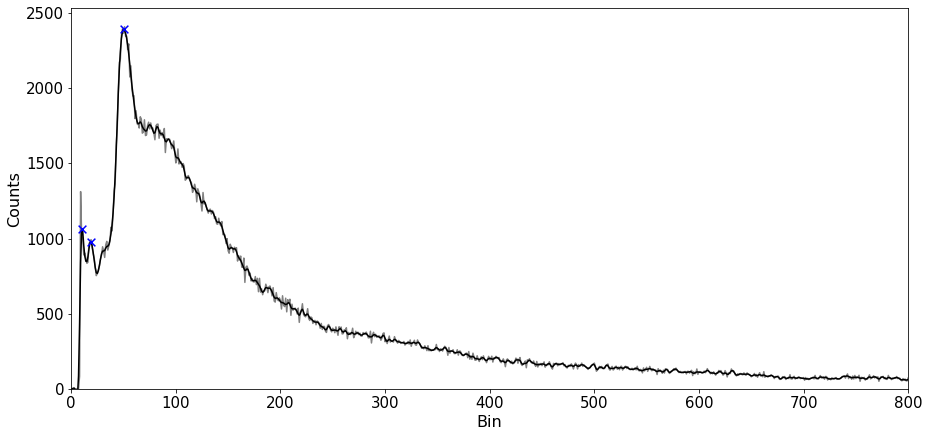

In [7]:
spectrum(Cs, 0.33, 300)
plt.xlim(0,500)
spectrum(Ba, 0.33, 400)
plt.xlim(0,500)
spectrum(bg, 0.37, 115)
plt.xlim(0,800)

In [8]:
peaks(Ba, 0.33, 300) # 19, 51, 179 and 209 used as Ba133 Ka1 and gammas

[[11, 19, 31, 51, 98, 179, 209, 369],
 [8396.957788122683,
  9968.516080902184,
  9121.830966076059,
  29742.624477953497,
  9447.595223703962,
  17003.877103368526,
  30956.600675451074,
  799.3643708411807]]

In [9]:
peaks(Cs, 0.33, 300) # 20, 29, 47 and 378 used as Cs137 Ka and KB, Pb Ka1 and Cs137 gamma decay

[[11, 20, 29, 47, 122, 241, 378],
 [10163.832617068856,
  12254.953734923944,
  11518.139839378393,
  19943.062825861838,
  15047.017406239851,
  11284.056414374167,
  17460.184669257244]]

In [10]:
peaks(bg, 0.37, 110) # 10 (8) used as Pb La1 or La2

[[10, 19, 50], [1059.9863777748292, 978.5459450693189, 2394.0949001526]]

In [11]:
# peaks are: 1st in bg, 2nd in Ba, 2nd 3rd and 4th in Cs, 4th 6th and 7th in Ba, last in Cs
#Pb La, Ba Ka, Cs Ka, Cs KB, Pb Ka, Pb KB, Ba gamma, Ba gamma, Cs gamma

peak_channel = [8, 19, 20, 29, 47, 51, 179, 209, 378] 
peak_energy = [10.5, 30.85, 32, 36.6,  75, 85, 302, 356, 662] # in keV

In [12]:
peak_x_err = [0, 1, 1, 1, 1, 0, 2, 2, 5] # error in peak position in units of energy bin widths (excluding effect of binning itself)


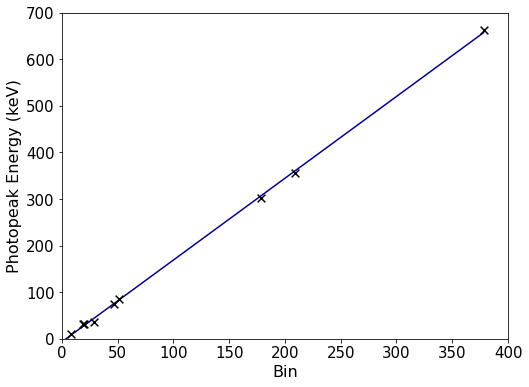

In [13]:
m = stat.linregress(peak_channel,peak_energy)[0]
b = stat.linregress(peak_channel,peak_energy)[1]
xrange = np.linspace(0,peak_channel[-1], len(peak_channel))

plt.figure(figsize=(8,6))
plt.scatter(peak_channel, peak_energy, zorder=1, marker='x', color='k', s=60)
plt.plot(xrange, [m*x + b for x in xrange], zorder=0, color='darkblue')
plt.errorbar(peak_channel, peak_energy,linestyle='',color='k',capsize=3)

plt.xlim(0,400)
plt.ylim(0,700)
plt.xlabel('Bin', size=16)
plt.ylabel('Photopeak Energy (keV)', size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [14]:
print(m,b)

1.7561914146976987 -6.763325535092946


In [15]:
def widths(df, Wn, prom, h, w):
    return sig.peak_widths(smooth(df, Wn), sig.find_peaks(smooth(df, Wn), prominence=prom)[0], rel_height=h, wlen=w)

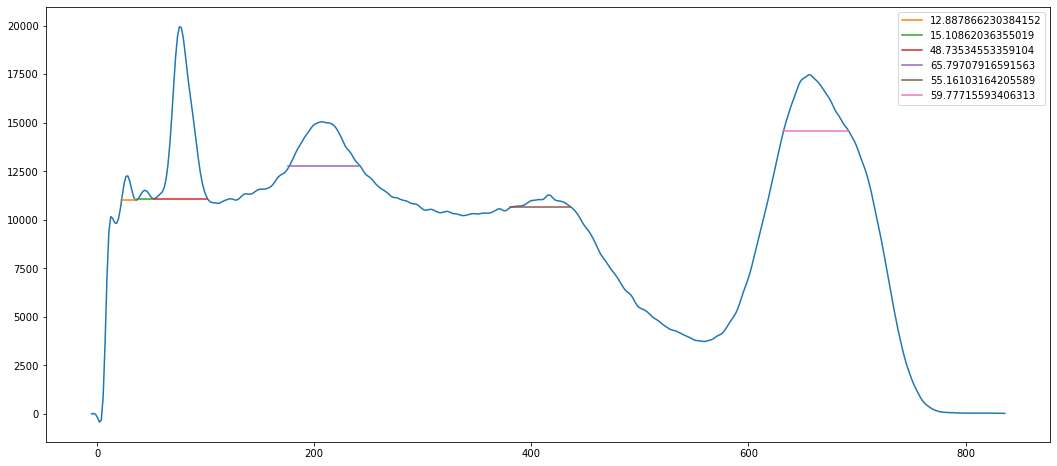

In [16]:
'''To identify widths of peaks, individually for each peak in each spectrum:
        - Peak width was set to be shown at a 'height' of 1, meaning the bottom of the peak as determined by scipy.signal
        - If this was incorrect, parameters width and prominence could be varied, often needed due to varying baseline signal
        - Once correct bottom of peak identified, without changing any other parameters, peak width was recorded at height of 0.5, the FWHM
        - Repeated for all peaks'''

plt.figure(figsize=(18,8))

h = 1
w = 40

plt.plot(m*Cs['Channel'][:480] + b, smooth(Cs, 0.33)[:480])
for left, right, height in zip(widths(Cs, 0.33, 400, h, w)[2], widths(Cs, 0.33, 400, h, w)[3], widths(Cs, 0.33, 400, h, w)[1]):
    plt.plot([m*left + b + 1, m*right + b + 1], [height, height], label=str((right-left)*m))
plt.legend()

In [23]:
Cs_FWHM = [7.34, 7.85, 18.94, 100.12] # for 2nd, 3rd, 4th and last peaks
Cs_FWHM_err = [0.4, 0.5, 1.5, 5] # using h = 0.45 to 0.55 (error in keV) excluding effect of binning

In [25]:
Ba_FWHM = [8.38, 14.85, 17.85, 37.42] # 2nd, 4th, 6th and 7th peaks
Ba_FWHM_err = [0.5, 1, 1, 2.5] # using h = 0.45 to 0.55 (error in keV) excluding effect of binning

In [27]:
bg_FWHM = 1.54 #1st peak
bg_FWHM_err = 0.2

In [28]:
binwidth = (max(Cs['Channel']) - min(Cs['Channel']))*m/1024

In [29]:
# peaks are: 1st in bg, 2nd in Ba, 2nd 3rd and 4th in Cs, 4th 6th and 7th in Ba, last in Cs

peak_FWHM = [bg_FWHM, Ba_FWHM[0], *Cs_FWHM[0:3], *Ba_FWHM[1:], Cs_FWHM[-1]]

FWHM_err = [bg_FWHM_err, Ba_FWHM_err[0], *Cs_FWHM_err[0:3], *Ba_FWHM_err[1:], Cs_FWHM_err[-1]]
peak_FWHM_err = [err + binwidth*2 for err in FWHM_err] # error in FWHM including effect of binning

In [30]:
resolution = [FWHM*100/E for FWHM, E in zip(peak_FWHM, peak_energy)]

In [31]:
# peaks are: 1st in bg, 2nd in Ba, 2nd 3rd and 4th in Cs, 4th 6th and 7th in Ba, last in Cs

peak_x_err = [0, 1, 1, 1, 1, 0, 2, 2, 5] # error in peak position in units of energy bin widths (excluding effect of binning itself)
peak_E_err = [(err + 1)*binwidth for err in peak_x_err] # error in peak E in keV including effecting of binning

In [32]:
resolution_err = [np.sqrt((delE/E)**2 + (delFWHM/FWHM)**2) for E, delE, FWHM, delFWHM in zip(peak_energy, peak_E_err, peak_FWHM, peak_FWHM_err)]

In [33]:
peak_E_err

[1.754476384019283,
 3.508952768038566,
 3.508952768038566,
 3.508952768038566,
 3.508952768038566,
 1.754476384019283,
 5.263429152057849,
 5.263429152057849,
 10.526858304115699]

In [34]:
resolution

[14.666666666666666,
 27.16369529983793,
 22.9375,
 21.44808743169399,
 25.253333333333337,
 17.470588235294116,
 5.910596026490067,
 10.51123595505618,
 15.123867069486405]

In [35]:
[res_err*res for res, res_err in zip(resolution, resolution_err) ]

[35.408271022611046,
 13.357232043426503,
 12.471734091138654,
 11.144766195343628,
 6.782307683030662,
 5.316893224421546,
 1.4965802536340203,
 1.6950472697810202,
 1.3076455491889147]